In [3]:
import geopandas as gpd
from joblib import Parallel, delayed
import ee
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

srtm = ee.Image("USGS/SRTMGL1_003")

def get_elevation(point):
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
    ee_point = ee.Geometry.Point([point.x, point.y])
    elevation = srtm.sample(ee_point, scale=30).first().get('elevation').getInfo()
    return elevation

detections = gpd.read_parquet(
    "gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_costa-rica_posw1.0.parquet")

# Get elevations in parallel
elevations = Parallel(n_jobs=-1, verbose=10)(
    delayed(get_elevation)(point) 
    for point in detections.geometry
)

detections['elevation'] = elevations
detections

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:  

,tile_id,prediction_probability,geometry,elevation
0,17PJM_20_0_10_31_2,0.585900,POINT (-83.99687 9.99361),1437
1,17PJM_20_0_10_42_4,0.815861,POINT (-83.9934 10.01352),1476
2,17PJM_20_0_10_22_10,0.932784,POINT (-83.98214 9.97749),1559
3,17PJM_20_0_10_173_10,0.729413,POINT (-83.98466 10.25026),443
4,17PJM_20_0_10_173_11,0.664395,POINT (-83.98284 10.25028),437
...,...,...,...,...
44677,16PHR_20_0_10_215_147,0.893805,POINT (-83.9992 9.61241),1758
44678,16PHR_20_0_10_216_147,0.997432,POINT (-83.99918 9.61421),1773
44679,16PHR_20_0_10_220_147,0.767586,POINT (-83.99912 9.62144),1982
44680,16PHR_20_0_10_221_147,0.989592,POINT (-83.9991 9.62325),1944


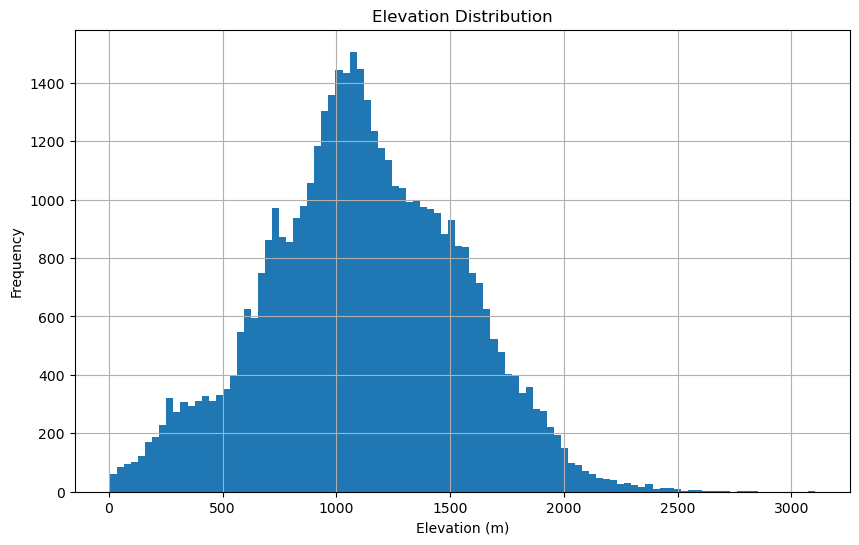

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
detections['elevation'].hist(bins=100)
plt.xlabel('Elevation (m)')
plt.ylabel('Frequency')
plt.title('Elevation Distribution')
plt.show()


In [13]:
# Calculate percentage below 600m
pct_below_600 = (detections['elevation'] < 180).mean() * 100
print(f"{pct_below_600:.1f}% of detections are below 600m elevation")


1.3% of detections are below 600m elevation


In [14]:
detections.to_file("gs://demeter-labs/coffee/detections/tile_classifier_predictions_v0_costa-rica_posw1.0_elevation.geojson", driver="GeoJSON")